## Summary

### Definition of model


### Results



In [1]:
import sys
sys.path.append('../../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.simulation import run_test

from matplotlib import pyplot as plt
from matplotlib import colors, patches
from scipy.stats import multivariate_normal
from scipy.signal import convolve2d
from sklearn.metrics import confusion_matrix

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(3)

## Variables

In [3]:
# Space and cells
space_shape = np.array([101,101])
cells = np.array([5,5])
space_center = (space_shape / 2).astype(int)

# Source
source_radius = 2
source_cell_resolution = np.array([5,5])
source_cell_shape = np.array([31,31])
# source_cell_shape = (np.array(space_shape) / cells).astype(int) #! Default but can be changed
source_cell_shape[source_cell_shape%2==0] += 1

## Building probabilities

In [4]:
indices = np.arange(space_shape[0])
x,y = np.meshgrid(indices, indices)
pos = np.dstack((x, y))
rv = multivariate_normal(space_center, 50)
probability_map = rv.pdf(pos)

# Normalize to have 1 at the center
probability_map /= np.max(probability_map)

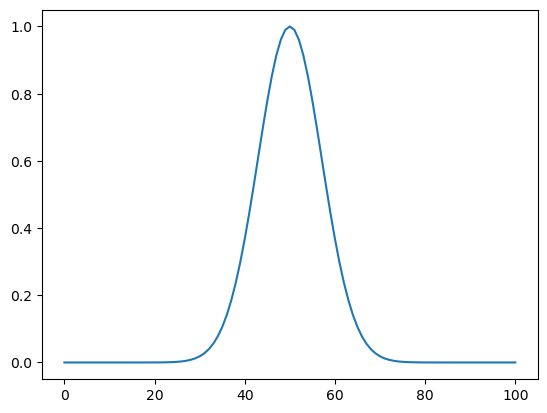

In [5]:
plt.plot(probability_map[50])

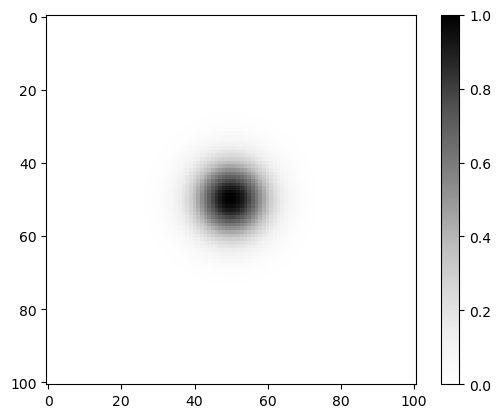

In [6]:
plt.imshow(probability_map, cmap='Greys')
plt.colorbar()

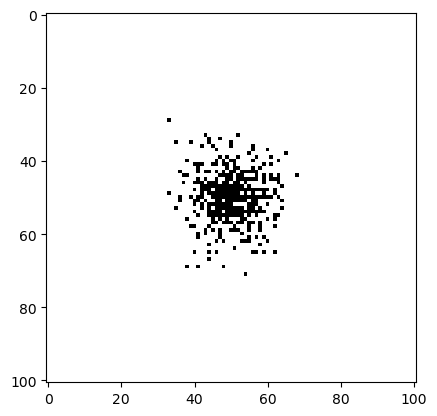

In [7]:
multiple_samples = (np.random.random((1000,101,101)) < probability_map).astype(float)

# Print sample
plt.imshow(multiple_samples[4], cmap='Greys')

## Model Definition

### Basic cells

In [8]:
def build_grid_mapping(space_shape: np.ndarray = np.array([101,101]),
                       cells: np.ndarray = np.array([3,3]),
                       source_radius: int = -1
                       ) -> np.ndarray:
    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        if ax_overflow > 0:
            sizes[:int(np.floor(ax_overflow/2))] += 1
            sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
    upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

    grid_cells = np.full(space_shape, -1)
    for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
        slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

        # Grid to cell mapping
        grid_cells[*slices] = i

    # Spacial indices
    spacial_indices = list(np.ndindex(tuple(space_shape)))
    spacial_indices_array = np.array(spacial_indices).astype(int)

    if source_radius >= 0:
        # Indices are at source
        at_source = np.sum(((space_shape / 2).astype(int) - spacial_indices_array) ** 2, axis=1) <= source_radius ** 2
        grid_cells[*spacial_indices_array[at_source].T] = -1

    return grid_cells

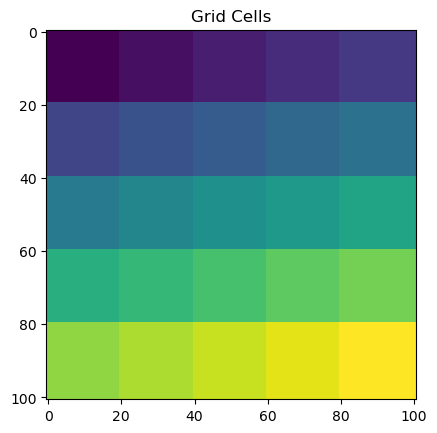

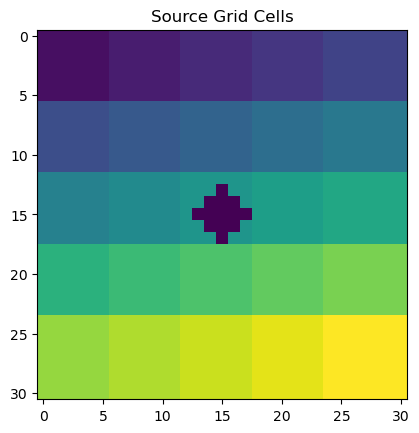

In [9]:
# grid_cells = build_grid_mapping(source_position=np.array([20,20]))
# grid_cells = build_grid_mapping(cells=np.array([5,5]))
# grid_cells = build_grid_mapping(source_cell_resolution=np.array([5,5]))
# grid_cells = build_grid_mapping()
grid_cells = build_grid_mapping(space_shape=space_shape, cells=cells)
grid_source_cells = build_grid_mapping(space_shape=source_cell_shape, cells=source_cell_resolution, source_radius=source_radius)

# Visualize
plt.imshow(grid_cells)
plt.title('Grid Cells')
plt.show()

plt.imshow(grid_source_cells)
plt.title('Source Grid Cells')
plt.show()

### State labels

In [10]:
# Get the list of all indices
indices_list = list(np.ndindex((*cells, *cells)))

In [11]:
cell_indices = list(np.ndindex((*cells,)))
source_cell_indices = list(np.ndindex((*source_cell_resolution,)))

state_labels = []
for (s_y, s_x) in cell_indices:
    for (a_y, a_x) in cell_indices:
        state_labels.append(f's_{s_y}_{s_x}-a_{a_y}_{a_x}')
state_labels += [f'sr_{source_y}_{source_x}' for (source_y, source_x) in source_cell_indices]
state_labels.append('goal')

# Print the indices list
state_labels[:10]

['s_0_0-a_0_0',
 's_0_0-a_0_1',
 's_0_0-a_0_2',
 's_0_0-a_0_3',
 's_0_0-a_0_4',
 's_0_0-a_1_0',
 's_0_0-a_1_1',
 's_0_0-a_1_2',
 's_0_0-a_1_3',
 's_0_0-a_1_4']

### Actions

In [12]:
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

### Transition probabilities

In [13]:
source_cell_arr = np.ones(source_cell_shape)
half_source_cell_shape = source_cell_shape // 2

cell_count = np.prod(cells)
source_cell_count = np.prod(source_cell_resolution)
source_grid_start_state = cell_count**2

# Cell indices array to facilitate the finding of the neighbouring cell indices
cell_indices_arr = np.array(cell_indices)


# Finding the sizes of the cells
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

# Determining cell sizes
cell_sizes = []
for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
    sizes = np.repeat(ax_size, ax_cells)
    if ax_overflow > 0:
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
    cell_sizes.append(sizes)

# Finding the edges of the cells and filling a grid with ids
cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T


# Building the amount of point going out to neighbour for the action vector
transition_probabilities = np.zeros((len(state_labels), len(action_labels), len(state_labels)))


for a, action_vect in enumerate(action_set):
    non_zero_action_component = (action_vect != 0)
    unit_action_vect = np.zeros(action_vect.shape)
    unit_action_vect[non_zero_action_component] = action_vect[non_zero_action_component] / np.abs(action_vect[non_zero_action_component])


    # Making an array of points that go to the source grid from its vicinity
    # Used in the computation of the average amount of points going to the source cell from anywhere
    points_reaching_source_cell = np.zeros(source_cell_shape + (2 * np.abs(action_vect)), dtype=int)
    points_reaching_source_cell[*[slice(abs(action_vect_dim), (dim_size - abs(action_vect_dim))) for dim_size, action_vect_dim in zip(points_reaching_source_cell.shape, action_vect)]] = -1
    points_reaching_source_cell[*[slice((abs(action_vect_dim) + action_vect_dim), (dim_size - abs(action_vect_dim) + action_vect_dim)) for dim_size, action_vect_dim in zip(points_reaching_source_cell.shape, action_vect)]] += 1
    points_reaching_source_cell[points_reaching_source_cell < 0] = 0


    # Computing the points landing in the source cell
    landing_points_in_source_cell = np.zeros(source_cell_shape, dtype=bool)
    landing_points_in_source_cell[slice(0, action_vect[0]) if action_vect[0] >= 0 else slice(action_vect[0], None), :] |= True
    landing_points_in_source_cell[:, slice(0, action_vect[1]) if action_vect[1] >= 0 else slice(action_vect[1], None)] |= True
    landing_points_in_source_cell = landing_points_in_source_cell.astype(int)

    # Apply the points landing in the source cell mask
    masked_grid_source_cells = grid_source_cells[landing_points_in_source_cell.astype(bool)]

    # Count points landing in each source cell and computing the landing probability
    unique_values, counts = np.unique(masked_grid_source_cells, return_counts=True)
    all_counts = np.array([(counts[np.argwhere(unique_values == source_cell_id)[0,0]] if source_cell_id in unique_values else 0) for source_cell_id in (np.arange(source_cell_count).tolist() + [-1])])
    source_cell_landing_probabilities = all_counts / np.sum(all_counts)


    # Making an array of points that leave the source grid
    inverse_action_vect = -action_vect
    points_leaving_source_cell = np.zeros(source_cell_shape + (2 * np.abs(inverse_action_vect)), dtype=int)
    points_leaving_source_cell[*[slice(abs(inverse_action_vect_dim), (dim_size - abs(inverse_action_vect_dim))) for dim_size, inverse_action_vect_dim in zip(points_leaving_source_cell.shape, inverse_action_vect)]] = -1
    points_leaving_source_cell[*[slice((abs(inverse_action_vect_dim) + inverse_action_vect_dim), (dim_size - abs(inverse_action_vect_dim) + inverse_action_vect_dim)) for dim_size, inverse_action_vect_dim in zip(points_leaving_source_cell.shape, inverse_action_vect)]] += 1
    points_leaving_source_cell[points_leaving_source_cell < 0] = 0


    # Loop over the cells where source is
    for i_cell_of_source, cell_of_source in enumerate(cell_indices_arr):
        cell_of_source_lower_bounds = lower_bounds[i_cell_of_source]
        cell_of_source_upper_bounds = upper_bounds[i_cell_of_source]

        i_source_grid_cell = (grid_cells == i_cell_of_source)
        i_source_grid_cell_padded = np.pad(i_source_grid_cell.astype(int), pad_width=half_source_cell_shape[:,None].repeat(2,axis=1), mode='constant', constant_values=0)

        i_source_cell_area = np.sum(i_source_grid_cell)

        points_reached_from_source_cell = np.zeros(cell_count)


        # Loop over the cells where agent is
        for i_cell_of_agent, cell_of_agent in enumerate(cell_indices_arr):
            cell_state_i = (i_cell_of_source * cell_count) + i_cell_of_agent

            cell_of_agent_lower_bounds = lower_bounds[i_cell_of_agent]
            cell_of_agent_upper_bounds = upper_bounds[i_cell_of_agent]

            i_agent_grid_cell = (grid_cells == i_cell_of_agent)
            i_agent_grid_cell_padded = np.pad(i_agent_grid_cell.astype(int), pad_width=half_source_cell_shape[:,None].repeat(2,axis=1), mode='constant', constant_values=0)
            i_agent_cell_area = np.sum(i_agent_grid_cell)

            # Computing the average amount of overlap for cell
            overlap_on_cell = convolve2d(i_agent_grid_cell_padded, source_cell_arr, mode='valid')
            assert all(overlap_on_cell.shape == space_shape)

            i_agent_overlap = overlap_on_cell[i_source_grid_cell]
            average_i_agent_overlap = np.sum(i_agent_overlap) / i_agent_cell_area


            # Computing the amount of points going out to neighbour cells
            # Vertical component
            vert_cell = cell_of_agent + np.array([unit_action_vect[0], 0])
            has_vert_cell = non_zero_action_component[0] and all((vert_cell >= 0) & (vert_cell < cells))
            if has_vert_cell:
                points_to_vert_neighbour_cell = np.zeros(i_agent_grid_cell.shape, dtype=int)
                points_to_vert_neighbour_cell[
                    slice((cell_of_agent_upper_bounds[0] - action_vect[0]), cell_of_agent_upper_bounds[0]) if (action_vect[0] >= 0) else slice(cell_of_agent_lower_bounds[0], (cell_of_agent_lower_bounds[0] - action_vect[0])),
                    slice(cell_of_agent_lower_bounds[1], (cell_of_agent_upper_bounds[1] - action_vect[1])) if (action_vect[1] >= 0) else slice((cell_of_agent_lower_bounds[1] - action_vect[1]), cell_of_agent_upper_bounds[1])
                ] = 1
                count_points_to_vert_neighbour_cell = np.sum(points_to_vert_neighbour_cell)
                points_to_vert_neighbour_cell_padded = np.pad(points_to_vert_neighbour_cell, pad_width=half_source_cell_shape[:,None].repeat(2,axis=1), mode='constant', constant_values=0)

                # Computing the overlap
                overlap_on_point_to_vert_neighbour = convolve2d(points_to_vert_neighbour_cell_padded, source_cell_arr, mode='valid')
                assert all(overlap_on_point_to_vert_neighbour.shape == space_shape)
                average_overlap_on_point_to_vert_neighbour = np.sum(overlap_on_point_to_vert_neighbour[i_source_grid_cell]) / i_source_cell_area

                # Computing amount of points leaving to neighbour
                vert_cell_index = np.argwhere(np.all(cell_indices_arr == vert_cell, axis=1))[0,0]
                vert_cell_state_i = (i_cell_of_source * cell_count) + vert_cell_index
                assert vert_cell_index != i_cell_of_agent
                leaving_to_vert_neighbour_count = (count_points_to_vert_neighbour_cell - average_overlap_on_point_to_vert_neighbour) # Remove the overlap!

                # Computing probability to move out to neighbour cell
                transition_probabilities[cell_state_i, a, vert_cell_state_i] = leaving_to_vert_neighbour_count / (i_agent_cell_area - average_i_agent_overlap)

            # Horizontal component
            hori_cell = cell_of_agent + np.array([0, unit_action_vect[1]])
            has_hori_cell = non_zero_action_component[1] and all((hori_cell >= 0) & (hori_cell < cells))
            if has_hori_cell:
                points_to_hori_neighbour_cell = np.zeros(i_agent_grid_cell.shape, dtype=int)
                points_to_hori_neighbour_cell[
                    slice(cell_of_agent_lower_bounds[0], (cell_of_agent_upper_bounds[0] - action_vect[0])) if action_vect[0] >= 0 else slice((cell_of_agent_lower_bounds[0] - action_vect[0]), cell_of_agent_upper_bounds[0]),
                    slice((cell_of_agent_upper_bounds[1] - action_vect[1]), cell_of_agent_upper_bounds[1]) if action_vect[1] >= 0 else slice(cell_of_agent_lower_bounds[1], (cell_of_agent_lower_bounds[1] - action_vect[1]))
                ] = 1
                count_points_to_hori_neighbour_cell = np.sum(points_to_hori_neighbour_cell)
                points_to_hori_neighbour_cell_padded = np.pad(points_to_hori_neighbour_cell, pad_width=half_source_cell_shape[:,None].repeat(2,axis=1), mode='constant', constant_values=0)

                # Computing the overlap
                overlap_on_point_to_hori_neighbour = convolve2d(points_to_hori_neighbour_cell_padded, source_cell_arr, mode='valid')
                assert all(overlap_on_point_to_hori_neighbour.shape == space_shape)
                average_overlap_on_point_to_hori_neighbour = np.sum(overlap_on_point_to_hori_neighbour[i_source_grid_cell]) / i_source_cell_area

                # Computing amount of points leaving to neighbour
                hori_cell_index = np.argwhere(np.all(cell_indices_arr == hori_cell, axis=1))[0,0]
                hori_cell_state_i = (i_cell_of_source * cell_count) + hori_cell_index
                assert hori_cell_index != i_cell_of_agent
                leaving_to_hori_neighbour_count = (count_points_to_hori_neighbour_cell - average_overlap_on_point_to_hori_neighbour) # Remove the overlap!

                # Computing probability to move out to neighbour cell
                transition_probabilities[cell_state_i, a, hori_cell_state_i] = leaving_to_hori_neighbour_count / (i_agent_cell_area - average_i_agent_overlap)

            # Diagonal component
            diag_cell = cell_of_agent + unit_action_vect
            if has_vert_cell and has_hori_cell:
                points_to_diag_neighbour_cell = np.zeros(i_agent_grid_cell.shape, dtype=int)
                points_to_diag_neighbour_cell[
                    slice((cell_of_agent_upper_bounds[0] - action_vect[0]), cell_of_agent_upper_bounds[0]) if action_vect[0] >= 0 else slice(cell_of_agent_lower_bounds[0], (cell_of_agent_lower_bounds[0] - action_vect[0])),
                    slice((cell_of_agent_upper_bounds[1] - action_vect[1]), cell_of_agent_upper_bounds[1]) if action_vect[1] >= 0 else slice(cell_of_agent_lower_bounds[1], (cell_of_agent_lower_bounds[1] - action_vect[1]))
                ] = 1
                count_points_to_diag_neighbour_cell = np.sum(points_to_diag_neighbour_cell)
                points_to_diag_neighbour_cell_padded = np.pad(points_to_diag_neighbour_cell, pad_width=half_source_cell_shape[:,None].repeat(2,axis=1), mode='constant', constant_values=0)

                # Computing the overlap
                overlap_on_point_to_diag_neighbour = convolve2d(points_to_diag_neighbour_cell_padded, source_cell_arr, mode='valid')
                assert all(overlap_on_point_to_diag_neighbour.shape == space_shape)
                average_overlap_on_point_to_diag_neighbour = np.sum(overlap_on_point_to_diag_neighbour[i_source_grid_cell]) / i_source_cell_area

                # Computing amount of points leaving to neighbour
                diag_cell_index = np.argwhere(np.all(cell_indices_arr == diag_cell, axis=1))[0,0]
                diag_cell_state_i = (i_cell_of_source * cell_count) + diag_cell_index
                assert diag_cell_index not in [i_cell_of_agent, vert_cell_index, hori_cell_index]
                leaving_to_diag_neighbour_count = (np.sum(count_points_to_diag_neighbour_cell) - average_overlap_on_point_to_diag_neighbour) # Remove the overlap!

                # Computing probability to move out to neighbour cell
                transition_probabilities[cell_state_i, a, diag_cell_state_i] = leaving_to_diag_neighbour_count / (i_agent_cell_area - average_i_agent_overlap)


            # Computing the average amount of points going to the source cells from anywhere
            i_agent_grid_cell_action_padded = np.pad(i_agent_grid_cell, pad_width=(half_source_cell_shape + np.abs(action_vect))[:,None].repeat(2,axis=1), mode='constant', constant_values=0)
            overlap_of_points_reaching_source = convolve2d(i_agent_grid_cell_action_padded, points_reaching_source_cell, mode='valid')
            assert all(overlap_of_points_reaching_source.shape == space_shape)
            average_out_to_source_cell = np.sum(overlap_of_points_reaching_source[i_source_grid_cell]) / i_source_cell_area # No filter to source cell because the point leaving the source cell are convolving!

            # Computing probability to move out to source cells
            to_source_grid_probability = average_out_to_source_cell / i_agent_cell_area
            transition_probabilities[cell_state_i, a, source_grid_start_state + np.arange(source_cell_count)] = to_source_grid_probability * source_cell_landing_probabilities[:-1]
            transition_probabilities[cell_state_i, a, -1] = to_source_grid_probability * source_cell_landing_probabilities[-1] # Goal state


            # Computing the average amount of points coming from the source cells from anywhere
            overlap_of_points_leaving_source = convolve2d(i_agent_grid_cell_action_padded, points_leaving_source_cell, mode='valid')
            assert all(overlap_of_points_leaving_source.shape == space_shape)
            average_out_from_source_cell = np.sum(overlap_of_points_leaving_source[i_source_grid_cell]) / i_source_cell_area # No filter to source cell because the point leaving the source cell are convolving!

            # Computing the average amount of points coming from the source cells
            points_reached_from_source_cell[i_cell_of_agent] = average_out_from_source_cell


        # Computing the transition probabilities to other source cell or out of the source grid
        source_grid_indices = np.array(list(np.ndindex(tuple(source_cell_shape))))
        moved_source_grid_indices = source_grid_indices + action_vect
        valid_moved_indices = np.all((moved_source_grid_indices >= 0) & (moved_source_grid_indices < source_cell_shape), axis=1)

        # Get the cell ids
        start_cell_ids = grid_source_cells[*source_grid_indices.T]
        target_cell_ids = np.full(start_cell_ids.shape, -2)
        target_cell_ids[valid_moved_indices] = grid_source_cells[*moved_source_grid_indices[valid_moved_indices].T]

        # Compute confusion matrix
        conf = confusion_matrix(start_cell_ids, target_cell_ids, labels=([-2, -1] + np.arange(source_cell_count).tolist()), normalize='true')

        # Setting zero probabilities to loop on themselves
        zero_probabilities = np.argwhere(conf.sum(axis=1)[2:] == 0)[:,0]
        conf[zero_probabilities + 2, zero_probabilities + 2] = 1.0

        # Set the transition probabilities
        transition_probabilities[source_grid_start_state:(source_grid_start_state + source_cell_count), a, source_grid_start_state:(source_grid_start_state + source_cell_count)] = conf[2:,2:]


        # To and from goal state
        transition_probabilities[source_grid_start_state:(source_grid_start_state + source_cell_count), a, -1] = conf[2:,1]
        # transition_probabilities[-1, a, -1] = 1.0
        transition_probabilities[-1, a, :-1] = 1.0 / (len(state_labels) - 1) # Loops back to any other state


        # Computing the transition probabilities from the source grid
        transition_probabilities[source_grid_start_state:(source_grid_start_state + source_cell_count), a, (i_cell_of_source * cell_count):((i_cell_of_source+1) * cell_count)] = (conf[2:,0][:,None] * (points_reached_from_source_cell / np.sum(points_reached_from_source_cell))[None,:]) / cell_count


        # Computing the probabilities to stay in the same cell
        i_source_cell_indices = (i_cell_of_source * cell_count) + np.arange(cell_count)
        transition_probabilities[i_source_cell_indices, a, i_source_cell_indices] = 1 - np.sum(transition_probabilities[i_source_cell_indices, a], axis=1)


assert np.all(transition_probabilities >= 0) and np.all(transition_probabilities <= 1.0) and np.all(np.sum(transition_probabilities, axis=2).round(8) == 1.0)

In [14]:
# # DEBUG

# source = 4 * cell_count
# agent = 5
# action = 1

# print(f'To other cell with action {action_labels[action]}')
# print(transition_probabilities[source+5, action, source:source+cell_count].reshape(cells))

# print(f'\nTo subgrid cell with action {action_labels[action]}')
# print(transition_probabilities[source+agent, action, -1-source_cell_count:-1].reshape(source_cell_resolution))

# print(f'\nTo other cell with action {action_labels[action+2]}')
# print(transition_probabilities[source+agent, action+2, source:source+cell_count].reshape(cells))

# print(f'\nTo subgrid cell with action {action_labels[action+2]}')
# print(transition_probabilities[source+agent, action+2, -1-source_cell_count:-1].reshape(source_cell_resolution))

### Observations

In [15]:
threshold = 3e-6

# Compute observation matrix
if not isinstance(threshold, list):
    threshold = [threshold]

# Ensure 0.0 and 1.0 begin and end the threshold list
if threshold[0] != -np.inf:
    threshold = [-np.inf] + threshold

if threshold[-1] != np.inf:
    threshold = threshold + [np.inf]

In [16]:
agent_state_labels = state_labels[:cell_count]

agent_state_labels[:5]

['s_0_0-a_0_0', 's_0_0-a_0_1', 's_0_0-a_0_2', 's_0_0-a_0_3', 's_0_0-a_0_4']

In [17]:
#  Observation labels
observation_labels = ['nothing']
if len(threshold) > 3:
    for i,_ in enumerate(threshold[1:-1]):
        observation_labels.append(f'something_l{i}')
else:
    observation_labels.append('something')

# Adding the agent position to the oservation labels
all_observation_labels = []
for obs in observation_labels:
    for agent_state in agent_state_labels:
        all_observation_labels.append(f'{agent_state}-{obs}')

observation_labels = all_observation_labels

# Add goal
observation_labels.append('goal')

### Observation Probabilities

In [18]:
# Splitting the center cell grid into subcells
sub_cell_size_standard = (source_cell_shape / source_cell_resolution).astype(int)
sub_cell_size_overflow = (source_cell_shape % source_cell_resolution).astype(int)

sub_cell_sizes = []
for ax_cells, ax_size, ax_overflow in zip(source_cell_resolution, sub_cell_size_standard, sub_cell_size_overflow):
    sizes = np.repeat(ax_size, ax_cells)
    if ax_overflow > 0:
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
    sub_cell_sizes.append(sizes)

# Finding the edges of the cells and filling a grid with ids
sub_cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in sub_cell_sizes]

sub_cell_lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in sub_cell_edges], indexing='ij')]).T
sub_cell_upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in sub_cell_edges], indexing='ij')]).T

# Finding the center cell and its lower bound
lower_bound_center_source_cell = space_center - (source_cell_shape / 2).astype(int)

sub_grid_cell_probabilities = np.full(source_cell_resolution, -1, dtype=float)
for cell, lower_b, upper_b in zip(list(np.ndindex(tuple(source_cell_resolution))), sub_cell_lower_bounds, sub_cell_upper_bounds):
    lower_b += lower_bound_center_source_cell
    upper_b += lower_bound_center_source_cell
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    sub_grid_cell_probabilities[*cell] = np.average(probability_map[*slices].astype(float))

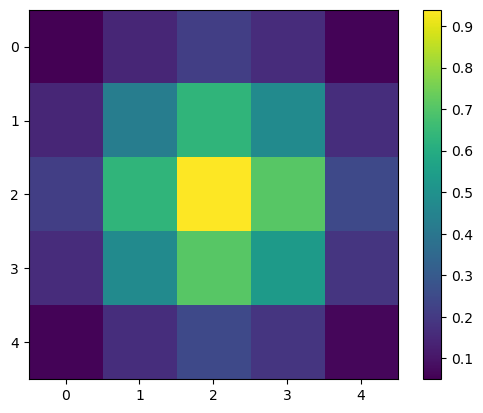

In [19]:
plt.imshow(sub_grid_cell_probabilities)
plt.colorbar()

In [20]:
# Generating an empty observation matrix
observations = np.zeros((len(state_labels), len(action_set), len(observation_labels)))

# Set chance to observe something out of the subgrid
small_non_zero_obs_chance = 0.0001
for i_source_cell in range(cell_count):
    observations[((np.arange(cell_count) * cell_count) + i_source_cell), :, i_source_cell + cell_count] = small_non_zero_obs_chance # Prob to observe something
    observations[((np.arange(cell_count) * cell_count) + i_source_cell), :, i_source_cell] = 1.0 - small_non_zero_obs_chance # Prob to observe nothing

# Set probabilities for the subgrid
source_cell_indices_arr = np.array(source_cell_indices)
sub_cell_cues = sub_grid_cell_probabilities[*source_cell_indices_arr.T]
observations[((cell_count**2) + np.arange(source_cell_count)), :, cell_count:cell_count*2] = (sub_cell_cues[:,None,None] / cell_count) # Prob to observe something
observations[((cell_count**2) + np.arange(source_cell_count)), :, :cell_count] = ((1.0 - sub_cell_cues[:,None,None]) / cell_count) # Prob to observe nothing

# Goal observations
observations[:,:,-1] = 0.0
observations[-1,:,-1] = 1.0 # Goal

assert np.all(observations.sum(axis=-1).round(8) == 1.0)

### Model

In [21]:
model = Model(
    states = state_labels,
    actions = action_labels,
    observations = observation_labels,
    transitions = transition_probabilities,
    observation_table = observations,
    end_states = [len(state_labels)-1], # The very last state is the goal state
    seed=12131415
)

## Training Agent

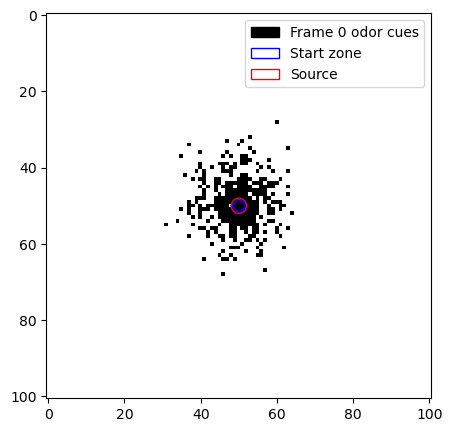

In [22]:
artificial_env  = Environment(data_file=multiple_samples,
                              data_source_position=[50, 50],
                              source_radius=2,
                              shape=[101,101],
                              boundary_condition='stop',
                              start_zone='data_zone',
                              odor_present_threshold=3e-1)

artificial_env.plot()

## FSVI agent

In [23]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                space_aware=True,
                spacial_subdivisions=cells,
                model=model)

In [24]:
_ = ag.train(expansions=300, use_gpu=True, gamma=0.999, eps=1e-10)

[01/22/2025, 17:56:26] MDP_policy, not provided. Solving MDP with Value Iteration...
[01/22/2025, 17:56:26] Sending Model to GPU...
[01/22/2025, 17:56:26]     > Done in 0.477s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 651-state, 4-action
  - Converged in 1000 iterations and 1.2760 seconds
  - Took on average 0.0013s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 651 state, 4 action, 51 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 1452 alpha vectors.
  - Converged in 163.8376s

  - Expand function took on average 0.0116s and yielded on average 771.58 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.5345s and yielded on average 4.83 alpha vectors per iteration. (0.0007s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


In [25]:
def plot_vf(vf, from_state, state_shape):
    # CUSTOM PLOT
    COLOR_LIST = [{
        'name': item.replace('tab:',''),
        'id': item,
        'hex': value,
        'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
        } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

    COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

    # VF
    # vf = ag.value_function
    new_shape = state_shape
    cell_count = np.prod(state_shape)

    # ! Select here which source to plot
    source_state_start = from_state
    # source_state_start = 0

    value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,source_state_start:source_state_start+cell_count]].reshape(new_shape)
    best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,source_state_start:source_state_start+cell_count]].reshape(new_shape)
    best_action_colors = COLOR_ARRAY[best_action_table]

    dimensions = new_shape

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

    # Ticks
    x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
    y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

    ax1.set_title('Value function')
    ax1_plot = ax1.imshow(value_table)

    if dimensions[0] >= dimensions[1]: # If higher than wide
        plt.colorbar(ax1_plot, ax=ax1)
    else:
        plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

    ax1.set_xticks(x_ticks)
    ax1.set_yticks(y_ticks)

    ax2.set_title('Action policy')
    ax2.imshow(best_action_colors)
    p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
    ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
    ax2.set_xticks(x_ticks)
    ax2.set_yticks(y_ticks)

    plt.show()

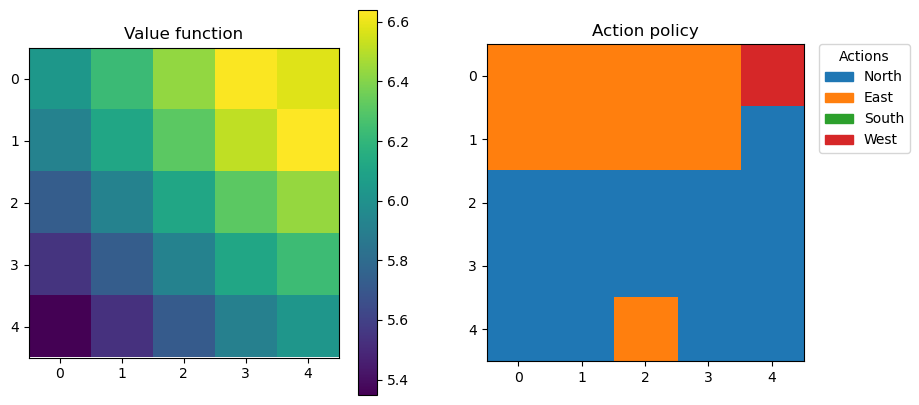

In [26]:
# MDP VF
source_cell = 4
source_state_start = source_cell * cell_count
plot_vf(ag.mdp_policy.to_cpu(), source_state_start, cells)

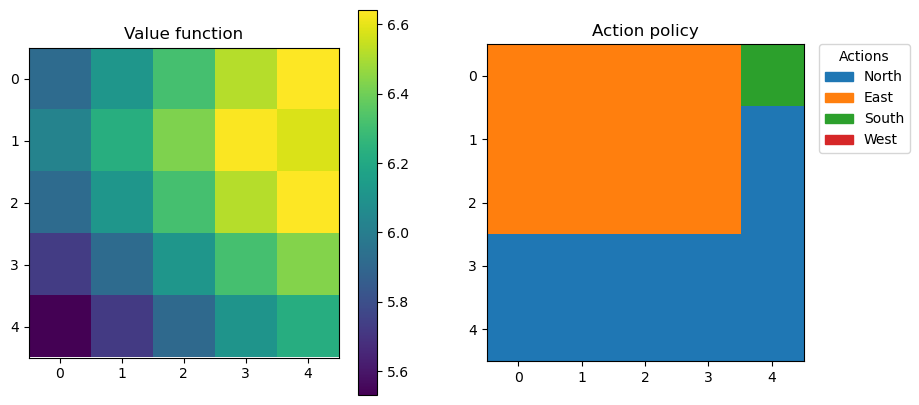

In [27]:
# MDP VF - Source subgrid
source_cell = 9
source_state_start = source_cell * cell_count
plot_vf(ag.mdp_policy.to_cpu(), source_state_start, source_cell_resolution)

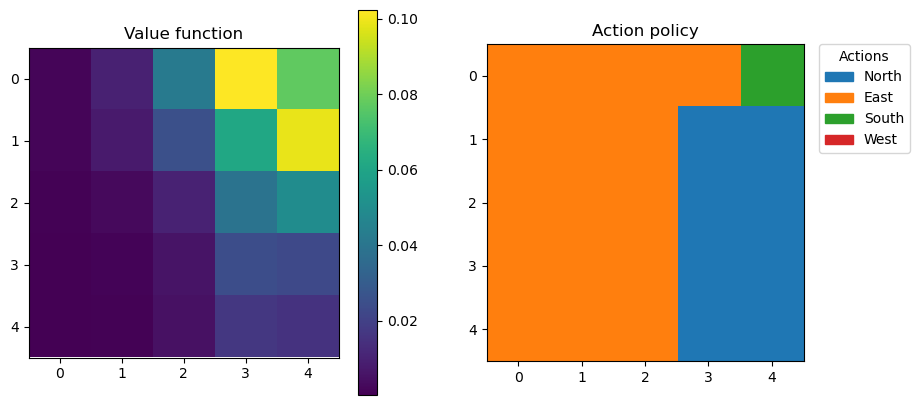

In [28]:
# POMDP VF
source_cell = 4
source_state_start = source_cell * cell_count
plot_vf(ag.value_function, source_state_start, cells)

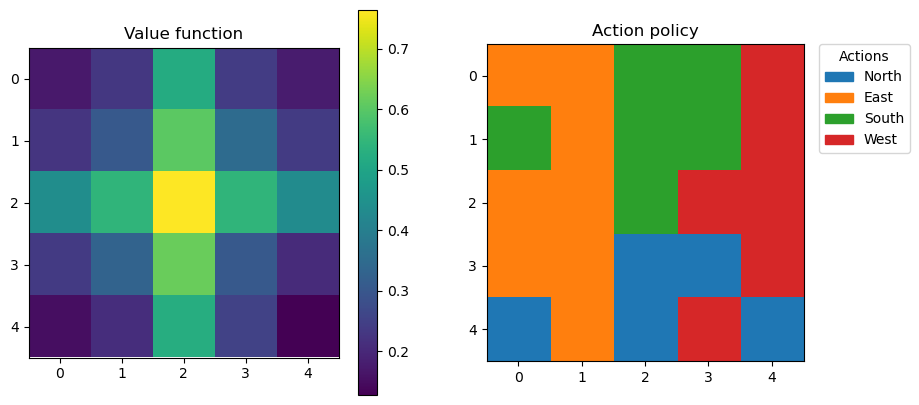

In [30]:
# POMDP VF - Source subgrid
source_cell = cell_count
source_state_start = source_cell * cell_count
plot_vf(ag.value_function, source_state_start, source_cell_resolution)

## Testing agent

In [31]:
# REPLACING WITH ARTIFICAL DATA !!
env = artificial_env
# !! Remove me

In [32]:
# Taking all starting points
start_points = np.argwhere(env.start_probabilities > 0)
n = len(start_points)

### Running test

In [33]:
hist = run_test(ag,
                n=n,
                horizon=1000,
                start_points=start_points,
                environment=env,
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Memory full: Out of memory allocating 34,488,417,792 bytes (allocated so far: 70,440,413,696 bytes).
Increasing the amount of batches...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Memory full: Out of memory allocating 17,244,209,152 bytes (allocated so far: 70,440,413,696 bytes).
Increasing the amount of batches...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 399.440s:
Simulations reached goal: 3909/10188 (6279 failures (reached horizon: 6279)) (38.37% success)
 - Average step count:                 756.718 +- 364.13 (Successful only: 365.936 +- 312.75)
 - Extra steps:                        708.160 +- 363.17 (Successful only: 318.416 +- 310.94)
 - Average discounted rewards (ADR):   0.078 +- 0.18 (Successful only: 0.204 +- 0.24)
 - Tmin/T:                             0.144 +- 0.21 (Successful only: 0.296 +- 0.28)


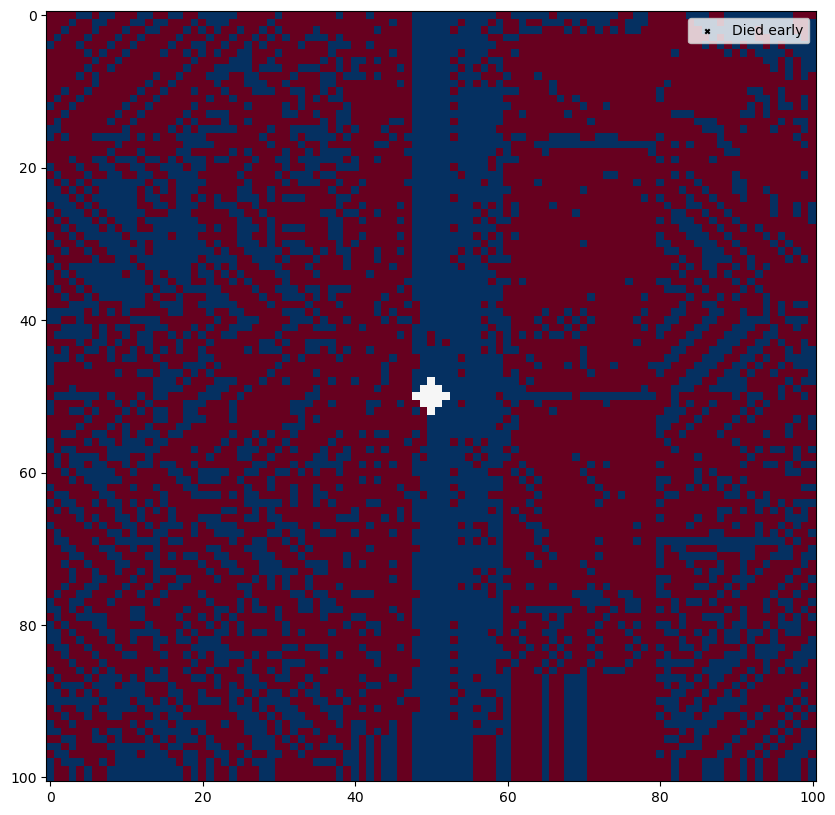

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot_successes(ax)

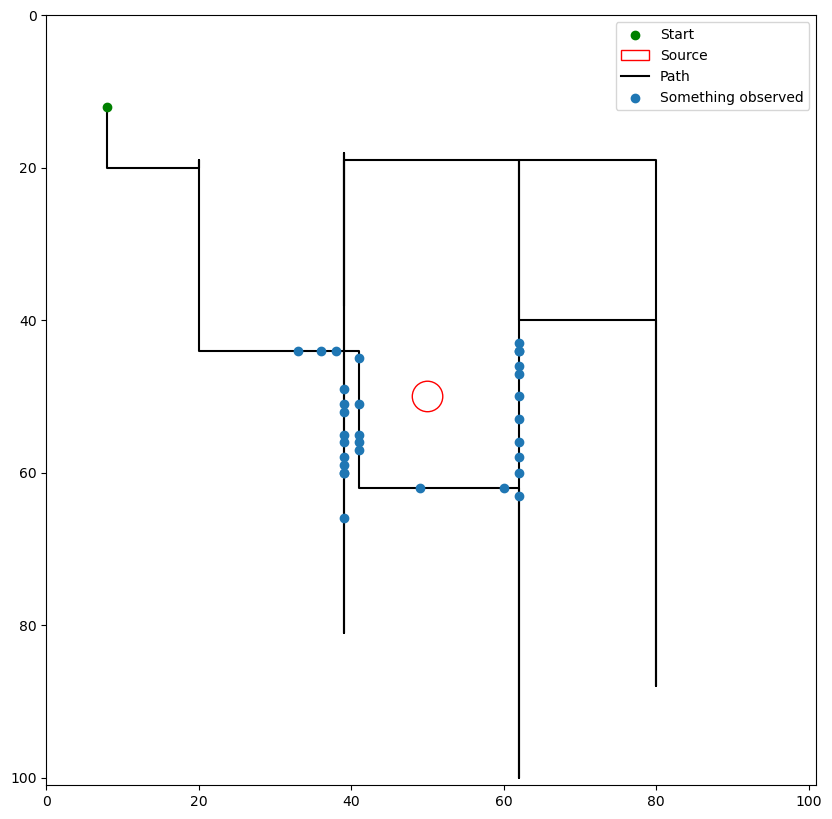

In [44]:
_, ax = plt.subplots(figsize=(10,10))
hist.plot(1220, ax= ax)

In [36]:
hist.simulation_dfs[1220]

,time,y,x,dy,dx,o,reached_source
0,0,12,8,None,None,None,None
1,1,13,8,1,0,0.0,0
2,2,14,8,1,0,0.0,0
3,3,15,8,1,0,0.0,0
4,4,16,8,1,0,0.0,0
...,...,...,...,...,...,...,...
996,996,42,39,-1,0,0.0,0
997,997,41,39,-1,0,0.0,0
998,998,40,39,-1,0,0.0,0
999,999,39,39,-1,0,0.0,0


In [47]:
bs = ag.generate_beliefs_from_trajectory(hist, 1220)

In [49]:
b_array = bs.belief_array

In [50]:
b0 = b_array[0]

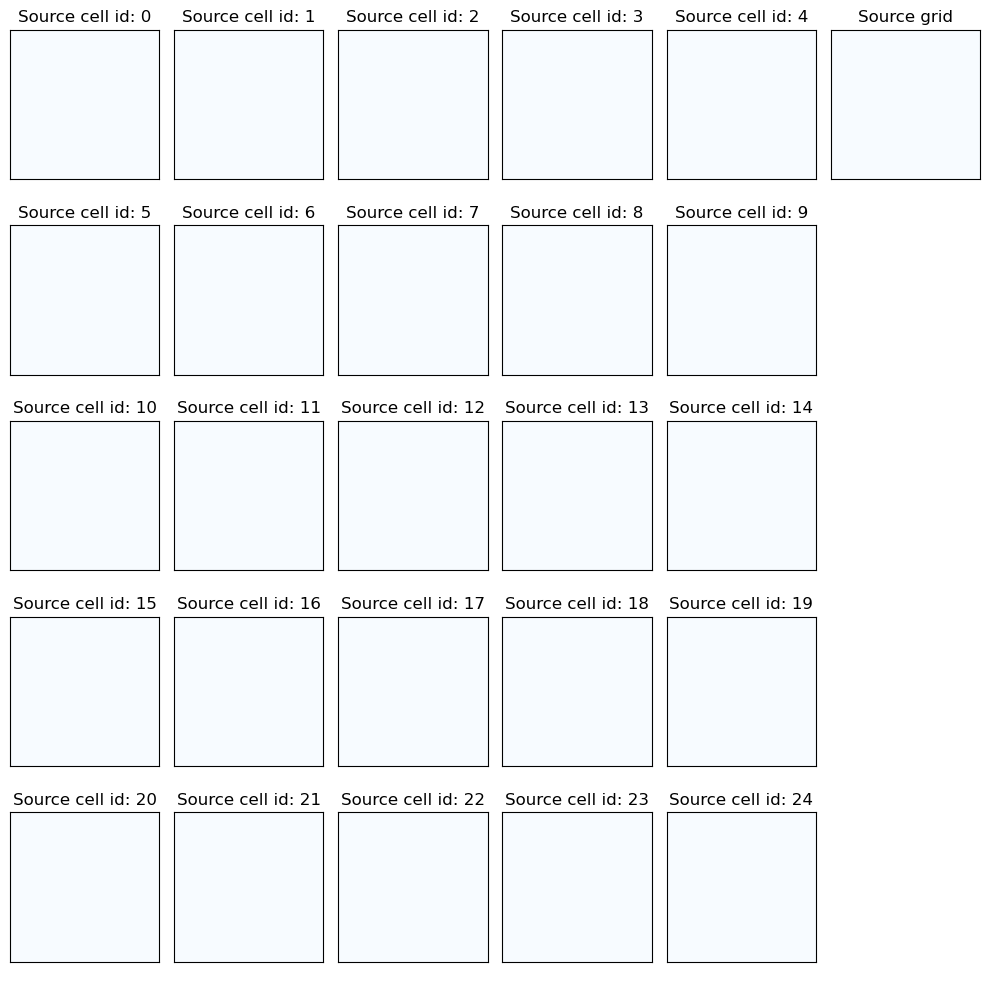

In [64]:
fig, axes = plt.subplots(ncols=cells[0] + 1, nrows=cells[1], figsize=(10, 10))

# Plot each subgrid
for i, cell in enumerate(cell_indices):
    ax = axes[*cell]
    subgrid_values = b0[(i * cell_count): ((i+1) * cell_count)].reshape(cells)
    ax.imshow(subgrid_values, cmap='Blues')
    ax.set_title(f'Source cell id: {i}')
    ax.set_xticks([])
    ax.set_yticks([])

different_array_values = b0[cell_count**2 : -1].reshape(source_cell_resolution)
ax = axes[0, -1]
ax.imshow(different_array_values, cmap='Blues')
ax.set_title('Source grid')
ax.set_xticks([])
ax.set_yticks([])

# Leave the last column blank
for ax in axes[1:, -1]:
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


In [ ]:
import matplotlib.animation as animation

fig, axes = plt.subplots(ncols=cells[0] + 1, nrows=cells[1], figsize=(10, 10))

def update_plot(frame):
    b0 = b_array[frame]
    for i, cell in enumerate(cell_indices):
        ax = axes[*cell]
        subgrid_values = b0[(i * cell_count): ((i+1) * cell_count)].reshape(cells)
        ax.imshow(subgrid_values, cmap='Blues')
        ax.set_title(f'Source cell id: {i}')
        ax.set_xticks([])
        ax.set_yticks([])

    different_array_values = b0[cell_count**2 : -1].reshape(source_cell_resolution)
    ax = axes[0, -1]
    ax.imshow(different_array_values, cmap='Blues')
    ax.set_title('Source grid')
    ax.set_xticks([])
    ax.set_yticks([])

    # Leave the last column blank
    for ax in axes[1:, -1]:
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

ani = animation.FuncAnimation(fig, update_plot, frames=len(b_array), repeat=False)
ani.save('beliefs_animation.mp4', writer='ffmpeg', fps=2)
plt.show()
